<a href="https://colab.research.google.com/github/hpsuresh12345/Python-code/blob/master/plot_model_complexity_influence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


# Model Complexity Influence


Demonstrate how model complexity influences both prediction accuracy and
computational performance.

The dataset is the Boston Housing dataset (resp. 20 Newsgroups) for
regression (resp. classification).

For each class of models we make the model complexity vary through the choice
of relevant model parameters and measure the influence on both computational
performance (latency) and predictive power (MSE or Hamming Loss).



Automatically created module for IPython interactive environment


Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.25, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)
Complexity: 4466 | Hamming Loss (Misclassification Ratio): 0.2491 | Pred. Time: 0.025807s

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.5, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
        

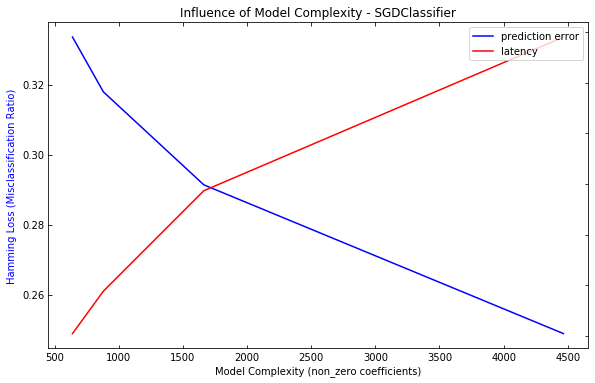

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 69 | MSE: 31.8139 | Pred. Time: 0.000325s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.25, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 136 | MSE: 25.6140 | Pred. Time: 0.000621s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 244 | MSE: 22.3375 | Pred. Time: 0.001477s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.75, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 351 | MSE: 21.3688 | Pred. Time: 0.001430s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, deg

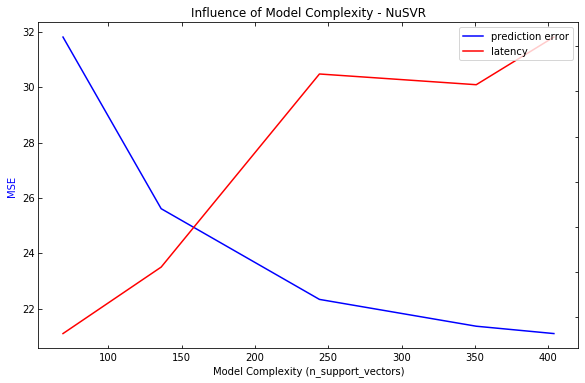

Benchmarking GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Complexity: 10 | MSE: 29.0148 | Pred. Time: 0.000158s

Benchmarking GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_

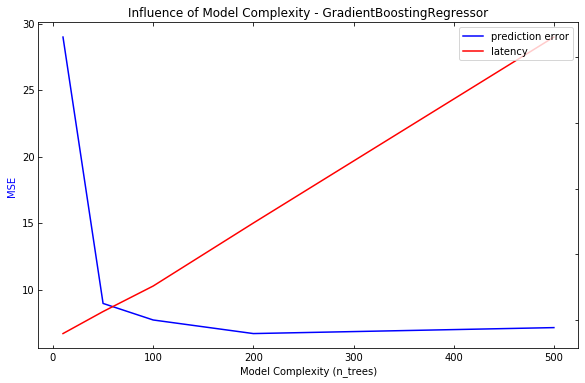

In [2]:
print(__doc__)

# Author: Eustache Diemert <eustache@diemert.fr>
# License: BSD 3 clause

import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm.classes import NuSVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import hamming_loss

# #############################################################################
# Routines


# Initialize random generator
np.random.seed(0)


def generate_data(case, sparse=False):
    """Generate regression/classification data."""
    bunch = None
    if case == 'regression':
        bunch = datasets.load_boston()
    elif case == 'classification':
        bunch = datasets.fetch_20newsgroups_vectorized(subset='all')
    X, y = shuffle(bunch.data, bunch.target)
    offset = int(X.shape[0] * 0.8)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    if sparse:
        X_train = csr_matrix(X_train)
        X_test = csr_matrix(X_test)
    else:
        X_train = np.array(X_train)
        X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}
    return data


def benchmark_influence(conf):
    """
    Benchmark influence of :changing_param: on both MSE and latency.
    """
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf['changing_param_values']:
        conf['tuned_params'][conf['changing_param']] = param_value
        estimator = conf['estimator'](**conf['tuned_params'])
        print("Benchmarking %s" % estimator)
        estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
        conf['postfit_hook'](estimator)
        complexity = conf['complexity_computer'](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf['n_samples']):
            y_pred = estimator.predict(conf['data']['X_test'])
        elapsed_time = (time.time() - start_time) / float(conf['n_samples'])
        prediction_times.append(elapsed_time)
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
        prediction_powers.append(pred_score)
        print("Complexity: %d | %s: %.4f | Pred. Time: %fs\n" % (
            complexity, conf['prediction_performance_label'], pred_score,
            elapsed_time))
    return prediction_powers, prediction_times, complexities


def plot_influence(conf, mse_values, prediction_times, complexities):
    """
    Plot influence of model complexity on both accuracy and latency.
    """
    plt.figure(figsize=(12, 6))
    host = host_subplot(111, axes_class=Axes)
    plt.subplots_adjust(right=0.75)
    par1 = host.twinx()
    host.set_xlabel('Model Complexity (%s)' % conf['complexity_label'])
    y1_label = conf['prediction_performance_label']
    y2_label = "Time (s)"
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    p1, = host.plot(complexities, mse_values, 'b-', label="prediction error")
    p2, = par1.plot(complexities, prediction_times, 'r-',
                    label="latency")
    host.legend(loc='upper right')
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    plt.title('Influence of Model Complexity - %s' % conf['estimator'].__name__)
    plt.show()


def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)

# #############################################################################
# Main code
regression_data = generate_data('regression')
classification_data = generate_data('classification', sparse=True)
configurations = [
    {'estimator': SGDClassifier,
     'tuned_params': {'penalty': 'elasticnet', 'alpha': 0.001, 'loss':
                      'modified_huber', 'fit_intercept': True, 'tol': 1e-3},
     'changing_param': 'l1_ratio',
     'changing_param_values': [0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'non_zero coefficients',
     'complexity_computer': _count_nonzero_coefficients,
     'prediction_performance_computer': hamming_loss,
     'prediction_performance_label': 'Hamming Loss (Misclassification Ratio)',
     'postfit_hook': lambda x: x.sparsify(),
     'data': classification_data,
     'n_samples': 30},
    {'estimator': NuSVR,
     'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
     'changing_param': 'nu',
     'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'n_support_vectors',
     'complexity_computer': lambda x: len(x.support_vectors_),
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
    {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_values': [10, 50, 100, 200, 500],
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
]
for conf in configurations:
    prediction_performances, prediction_times, complexities = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)